In [1]:
from IPython.display import Image

In [2]:
!python plot_gpr_noisy.py

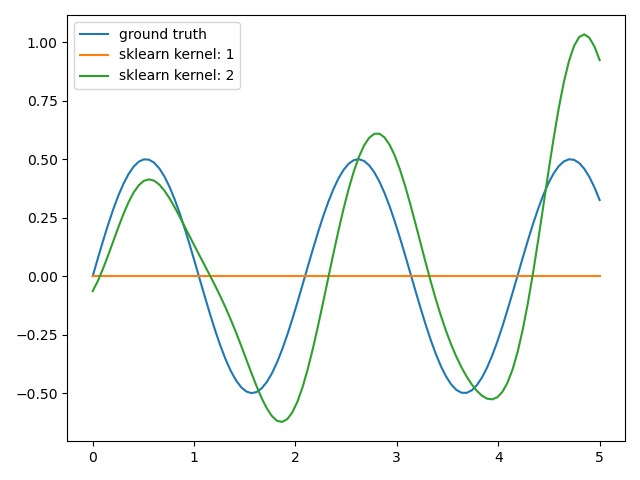

In [3]:
Image(filename='plots/sklearn_kernel.png') 

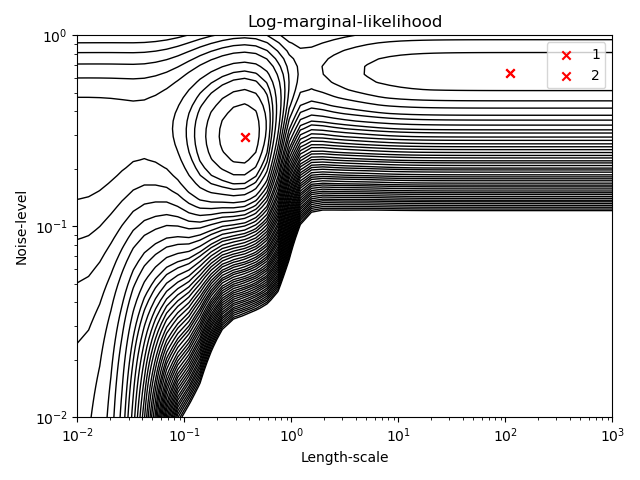

In [4]:
Image(filename='plots/sklearn_lml.png') 

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
LML = np.load('data/lml_arr.npy')

In [9]:
!python sklearn_example.py

HGDL -----------------------------------------------------------
{'best_x': array([-0.89335897, -1.00663604, -1.22409354]), 'best_y': 21.805090890127566, 'minima_x': array([[ -0.89335897,  -1.00663604,  -1.22409354],
       [ -1.18743966,  -4.60516998,  -1.10211376],
       [ -1.48558452,  -4.52131262,  -0.88964983],
       [-11.15080124,  -3.64699797,  -0.4506687 ],
       [-11.51290289,  -4.60516725,  -0.45066166]]), 'minima_y': array([21.80509089, 23.86915829, 23.86915829, 23.87231025, 23.87231125]), 'global_x': array([[-0.31215015, -0.86825259, -0.61383187],
       [-0.75920449, -1.82225315, -0.71580304],
       [-2.569015  , -1.93116684, -0.48312488],
       [-6.94736704, -3.66418796, -0.49182849],
       [-8.83310001, -2.51427352, -0.24009371]]), 'global_y': array([23.20718822, 23.35400295, 23.47507337, 23.88017392, 24.07929736])}
gp - HGDL ( 1 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294

In [10]:
thetas = np.load('data/hgdl_thetas.npy')

In [11]:
thetas

array([[ -0.89335897,  -1.00663604,  -1.22409354],
       [ -1.18743966,  -4.60516998,  -1.10211376],
       [ -1.48558452,  -4.52131262,  -0.88964983],
       [-11.15080124,  -3.64699797,  -0.4506687 ],
       [-11.51290289,  -4.60516725,  -0.45066166]])

[0.36544626 0.01       0.01087474 0.02606927 0.01000003] [0.2940241  0.33216822 0.41079958 0.63720191 0.6372064 ]
[0.36544626 0.01       0.01087474 0.02606927 0.01000003] [0.2940241  0.33216822 0.41079958 0.63720191 0.6372064 ]
[0.36544626 0.01       0.01087474 0.02606927 0.01000003] [0.2940241  0.33216822 0.41079958 0.63720191 0.6372064 ]
[0.36544626 0.01       0.01087474 0.02606927 0.01000003] [0.2940241  0.33216822 0.41079958 0.63720191 0.6372064 ]
[0.36544626 0.01       0.01087474 0.02606927 0.01000003] [0.2940241  0.33216822 0.41079958 0.63720191 0.6372064 ]


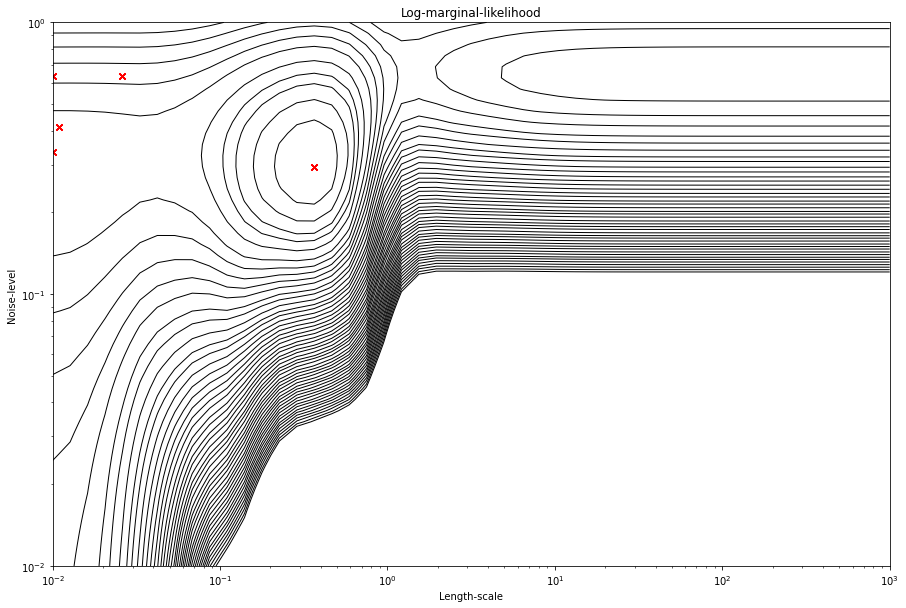

In [12]:
plt.figure(figsize=(15,10))

theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
from matplotlib.colors import LogNorm

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            #levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
            levels=level, colors='black', linewidths=1., norm=LogNorm(vmin=vmin, vmax=vmax))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood");
x, y = np.exp(thetas[:,1]), np.exp(thetas[:,2])
for i, (pt_x, pt_y) in enumerate(zip(x,y)):
    name = str(i+1)
    plt.scatter(x, y, c='red', marker='x', label=name)
    print(x,y)